# Sin tratar los datos

Primero, **cargamos las librerías** que vamos a utilizar a lo largo de todo el cuaderno.

In [121]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import matplotlib.pyplot as plt # this is used for the plot the graph
from matplotlib.colors import ListedColormap # this is used for the plot the graph
import matplotlib.patches as mpatches # this is used for the plot the graph
import seaborn as sns # used for plot interactive graph.
from sklearn.metrics import confusion_matrix # this is used for finding confusion matrix

%matplotlib inline 
plt.rcParams['figure.figsize'] = (16, 9) # this is used for setting the size of the plot
plt.style.use('ggplot') # this is used for the style of the plot

from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.neighbors import KNeighborsClassifier # for K nearest neighbours
from sklearn.tree import DecisionTreeClassifier # for using Decision Tree Algoithm
from sklearn.naive_bayes import GaussianNB # for Naive Bayes Algorithm
from sklearn.metrics import classification_report # for classification report
from sklearn.tree import export_graphviz # for exporting dot data
from io import StringIO # for working with stream
from IPython.display import Image # for displaying image  
import pydotplus # for dot data
from sklearn.preprocessing import LabelEncoder # for encoding

Ahora, **cargamos los datos** del fichero csv.

In [122]:
dataframe = pd.read_csv(r"homeLoanAproval.csv",sep=',')
# Mostramos los diez primeros elementos
dataframe.head(10)

Loan_ID Gender Married Dependents     Education SelfEmployed  \
0  LP001002   Male      No          0      Graduate           No   
1  LP001003   Male     Yes          1      Graduate           No   
2  LP001005   Male     Yes          0      Graduate          Yes   
3  LP001006   Male     Yes          0  Not Graduate           No   
4  LP001008   Male      No          0      Graduate           No   
5  LP001011   Male     Yes          2      Graduate          Yes   
6  LP001013   Male     Yes          0  Not Graduate           No   
7  LP001014   Male     Yes         3+      Graduate           No   
8  LP001018   Male     Yes          2      Graduate           No   
9  LP001020   Male     Yes          1      Graduate           No   

   ApplicantIncome CoapplicantIncome  LoanAmount  LoanAmountTerm PropertyArea  \
0             5849                 0         NaN           360.0        Urban   
1             4583              1508       128.0           360.0        Rural   
2             3000                 0        66.0           360.0        Urban   
3             2583              2358       120.0           360.0        Urban   
4             6000                 0       141.0           360.0        Urban   
5             5417              4196       267.0           360.0        Urban   
6             2333              1516        95.0           360.0        Urban   
7             3036              2504       158.0           360.0    Semiurban   
8             4006              1526       168.0           360.0        Urban   
9            12841             10968       349.0           360.0    Semiurban   

  LoanStatus  
0          Y  
1          N  
2          Y  
3          Y  
4          Y  
5          Y  
6          Y  
7          N  
8          Y  
9          N

Como en este caso no estamos tratabdo los datos, **borraremos** cualquier fila que tenga algún valor incorrecto.

In [123]:
# Borramos las filas a las que les falta algún dato
dataframe.dropna(how="any", inplace=True)

# Borramos las filas que tienen algún dato '3+'
dataframe = dataframe[dataframe.Dependents != '3+']
# La pasamos a numérica
dataframe['Dependents'] = dataframe['Dependents'].apply(pd.to_numeric)

# Borramos filas de Coaplicant que no tengan un valor numérico válido
# Es decir, números con puntos como separador
dataframe = dataframe[dataframe.CoapplicantIncome.str.contains('^\d+.\d+$')]
# La pasamos a numérica
dataframe['CoapplicantIncome'] = dataframe['CoapplicantIncome'].apply(pd.to_numeric)

Comprobamos los **tipos** de los datos.

In [124]:
# Resumen de los tipos de datos
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 268 entries, 1 to 611
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            268 non-null    object 
 1   Gender             268 non-null    object 
 2   Married            268 non-null    object 
 3   Dependents         268 non-null    int64  
 4   Education          268 non-null    object 
 5   SelfEmployed       268 non-null    object 
 6   ApplicantIncome    268 non-null    int64  
 7   CoapplicantIncome  268 non-null    int64  
 8   LoanAmount         268 non-null    float64
 9   LoanAmountTerm     268 non-null    float64
 10  PropertyArea       268 non-null    object 
 11  LoanStatus         268 non-null    object 
dtypes: float64(2), int64(3), object(7)
memory usage: 27.2+ KB


Como no estamos tratando nada, todas las columnas **categóricas** las vamos a quitar; pues para usarlas tendríamos que hacer modificaciones.

In [125]:
# Quitamos las columnas categóricas
dataframe = dataframe.drop('Gender', axis=1)
dataframe = dataframe.drop('Married', axis=1)
dataframe = dataframe.drop('Education', axis=1)
dataframe = dataframe.drop('SelfEmployed', axis=1)
dataframe = dataframe.drop('PropertyArea', axis=1)
# Quitamos también el LOAD_ID, pues no nos hace falta
dataframe = dataframe.drop('Loan_ID', axis=1)

In [126]:
# Comprobamos que se han quitado
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 268 entries, 1 to 611
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Dependents         268 non-null    int64  
 1   ApplicantIncome    268 non-null    int64  
 2   CoapplicantIncome  268 non-null    int64  
 3   LoanAmount         268 non-null    float64
 4   LoanAmountTerm     268 non-null    float64
 5   LoanStatus         268 non-null    object 
dtypes: float64(2), int64(3), object(1)
memory usage: 14.7+ KB


Ahora que tenemos nuestro dataframe "preparado", hagamos los grupos de **entrenamiento** y de **testeo**. De nuevo, como no estamos realizando una preparación previa, separamos completamente al azar.

In [127]:
x = dataframe.drop('LoanStatus', axis=1)
y = dataframe['LoanStatus'].values

In [128]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

No vamos a **escalar** los datos en este paso. Pasemos directamente a los algoritmos de clasificación.

## K-Vecinos

Estableceremos el número de vecinos al **azar** de momento. Luego lo **ajustaremos** a lo sea más apropiado.

In [129]:
n_neighbors = 7

knn = KNeighborsClassifier(n_neighbors)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [130]:
print('Accuracy of K-NN classifier on training set: {:.2f}'.format(knn.score(x_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(knn.score(x_test, y_test)))

Accuracy of K-NN classifier on training set: 0.77
Accuracy of K-NN classifier on test set: 0.69


Aparentemente nuestro clasificador es bastante bueno, sin embargo, veamos la **matriz de confusión** del mismo.

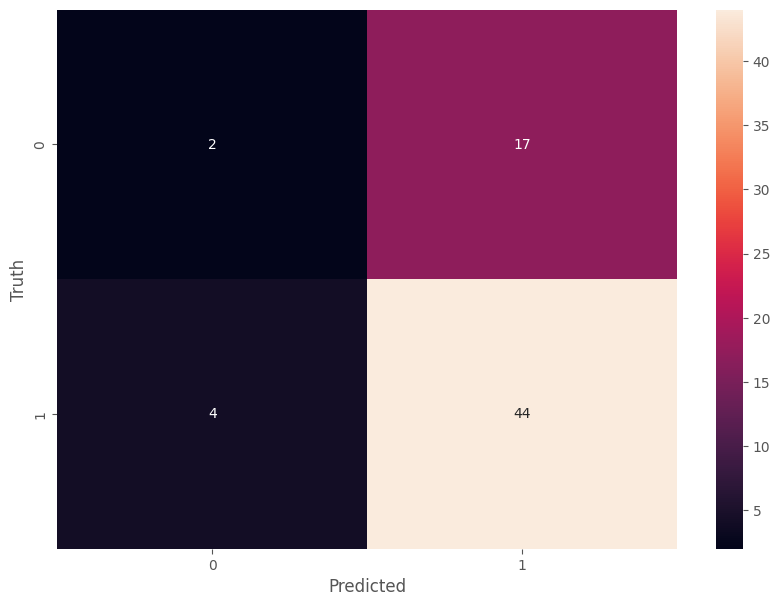

In [131]:
# Calcular la matriz de confusión
pred = knn.predict(x_test)
cm = confusion_matrix(y_test, pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

plt.show()

Aquí podemos ver que realmente nuestro clasificador **no está haciendo un buen trabajo** del todo:
- El modelo predijo correctamente que 2 instancias eran de la clase 'N' (verdaderos negativos).
- El modelo predijo incorrectamente que 17 instancias eran de la clase 'Y' cuando en realidad eran de la clase 'N' (falsos positivos).
- El modelo predijo incorrectamente que 4 instancias eran de la clase 'N' cuando en realidad eran de la clase 'Y' (falsos negativos).
- El modelo predijo correctamente que 44 instancias eran de la clase 'Y' (verdaderos positivos).    

Es decir, nuestro modelo **suele clasificar todo como "sí"**, así que no es un buen modelo.

## Árbol de clasificación

Hagamos ahora un **árbol de clasificación**.

In [132]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

In [133]:
clf = DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

In [134]:
print('Accuracy of classifier on training set: {:.2f}'.format(clf.score(x_train, y_train)))
print('Accuracy of classifier on test set: {:.2f}'.format(clf.score(x_test, y_test)))

Accuracy of classifier on training set: 1.00
Accuracy of classifier on test set: 0.58


Ya podemos ver que nuestro árbol está **demasiado ajustado** a los datos con los que está entrenando. Veamos su **matriz de confusión**.

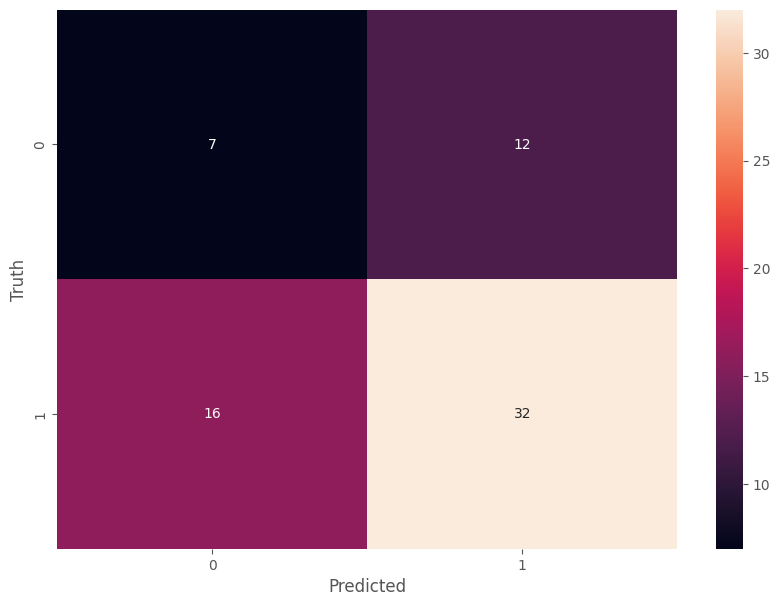

In [135]:
pred = clf.predict(x_test)
cm = confusion_matrix(y_test, pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

plt.show()

Es cierto que ahora *no siempre clasifica en sí*, pero seguimos teniendo muy mala predicción. Veamos el árbol generado.

In [136]:
dataframe.head()

Dependents  ApplicantIncome  CoapplicantIncome  LoanAmount  LoanAmountTerm  \
1           1             4583               1508       128.0           360.0   
3           0             2583               2358       120.0           360.0   
5           2             5417               4196       267.0           360.0   
6           0             2333               1516        95.0           360.0   
8           2             4006               1526       168.0           360.0   

  LoanStatus  
1          N  
3          Y  
5          Y  
6          Y  
8          Y

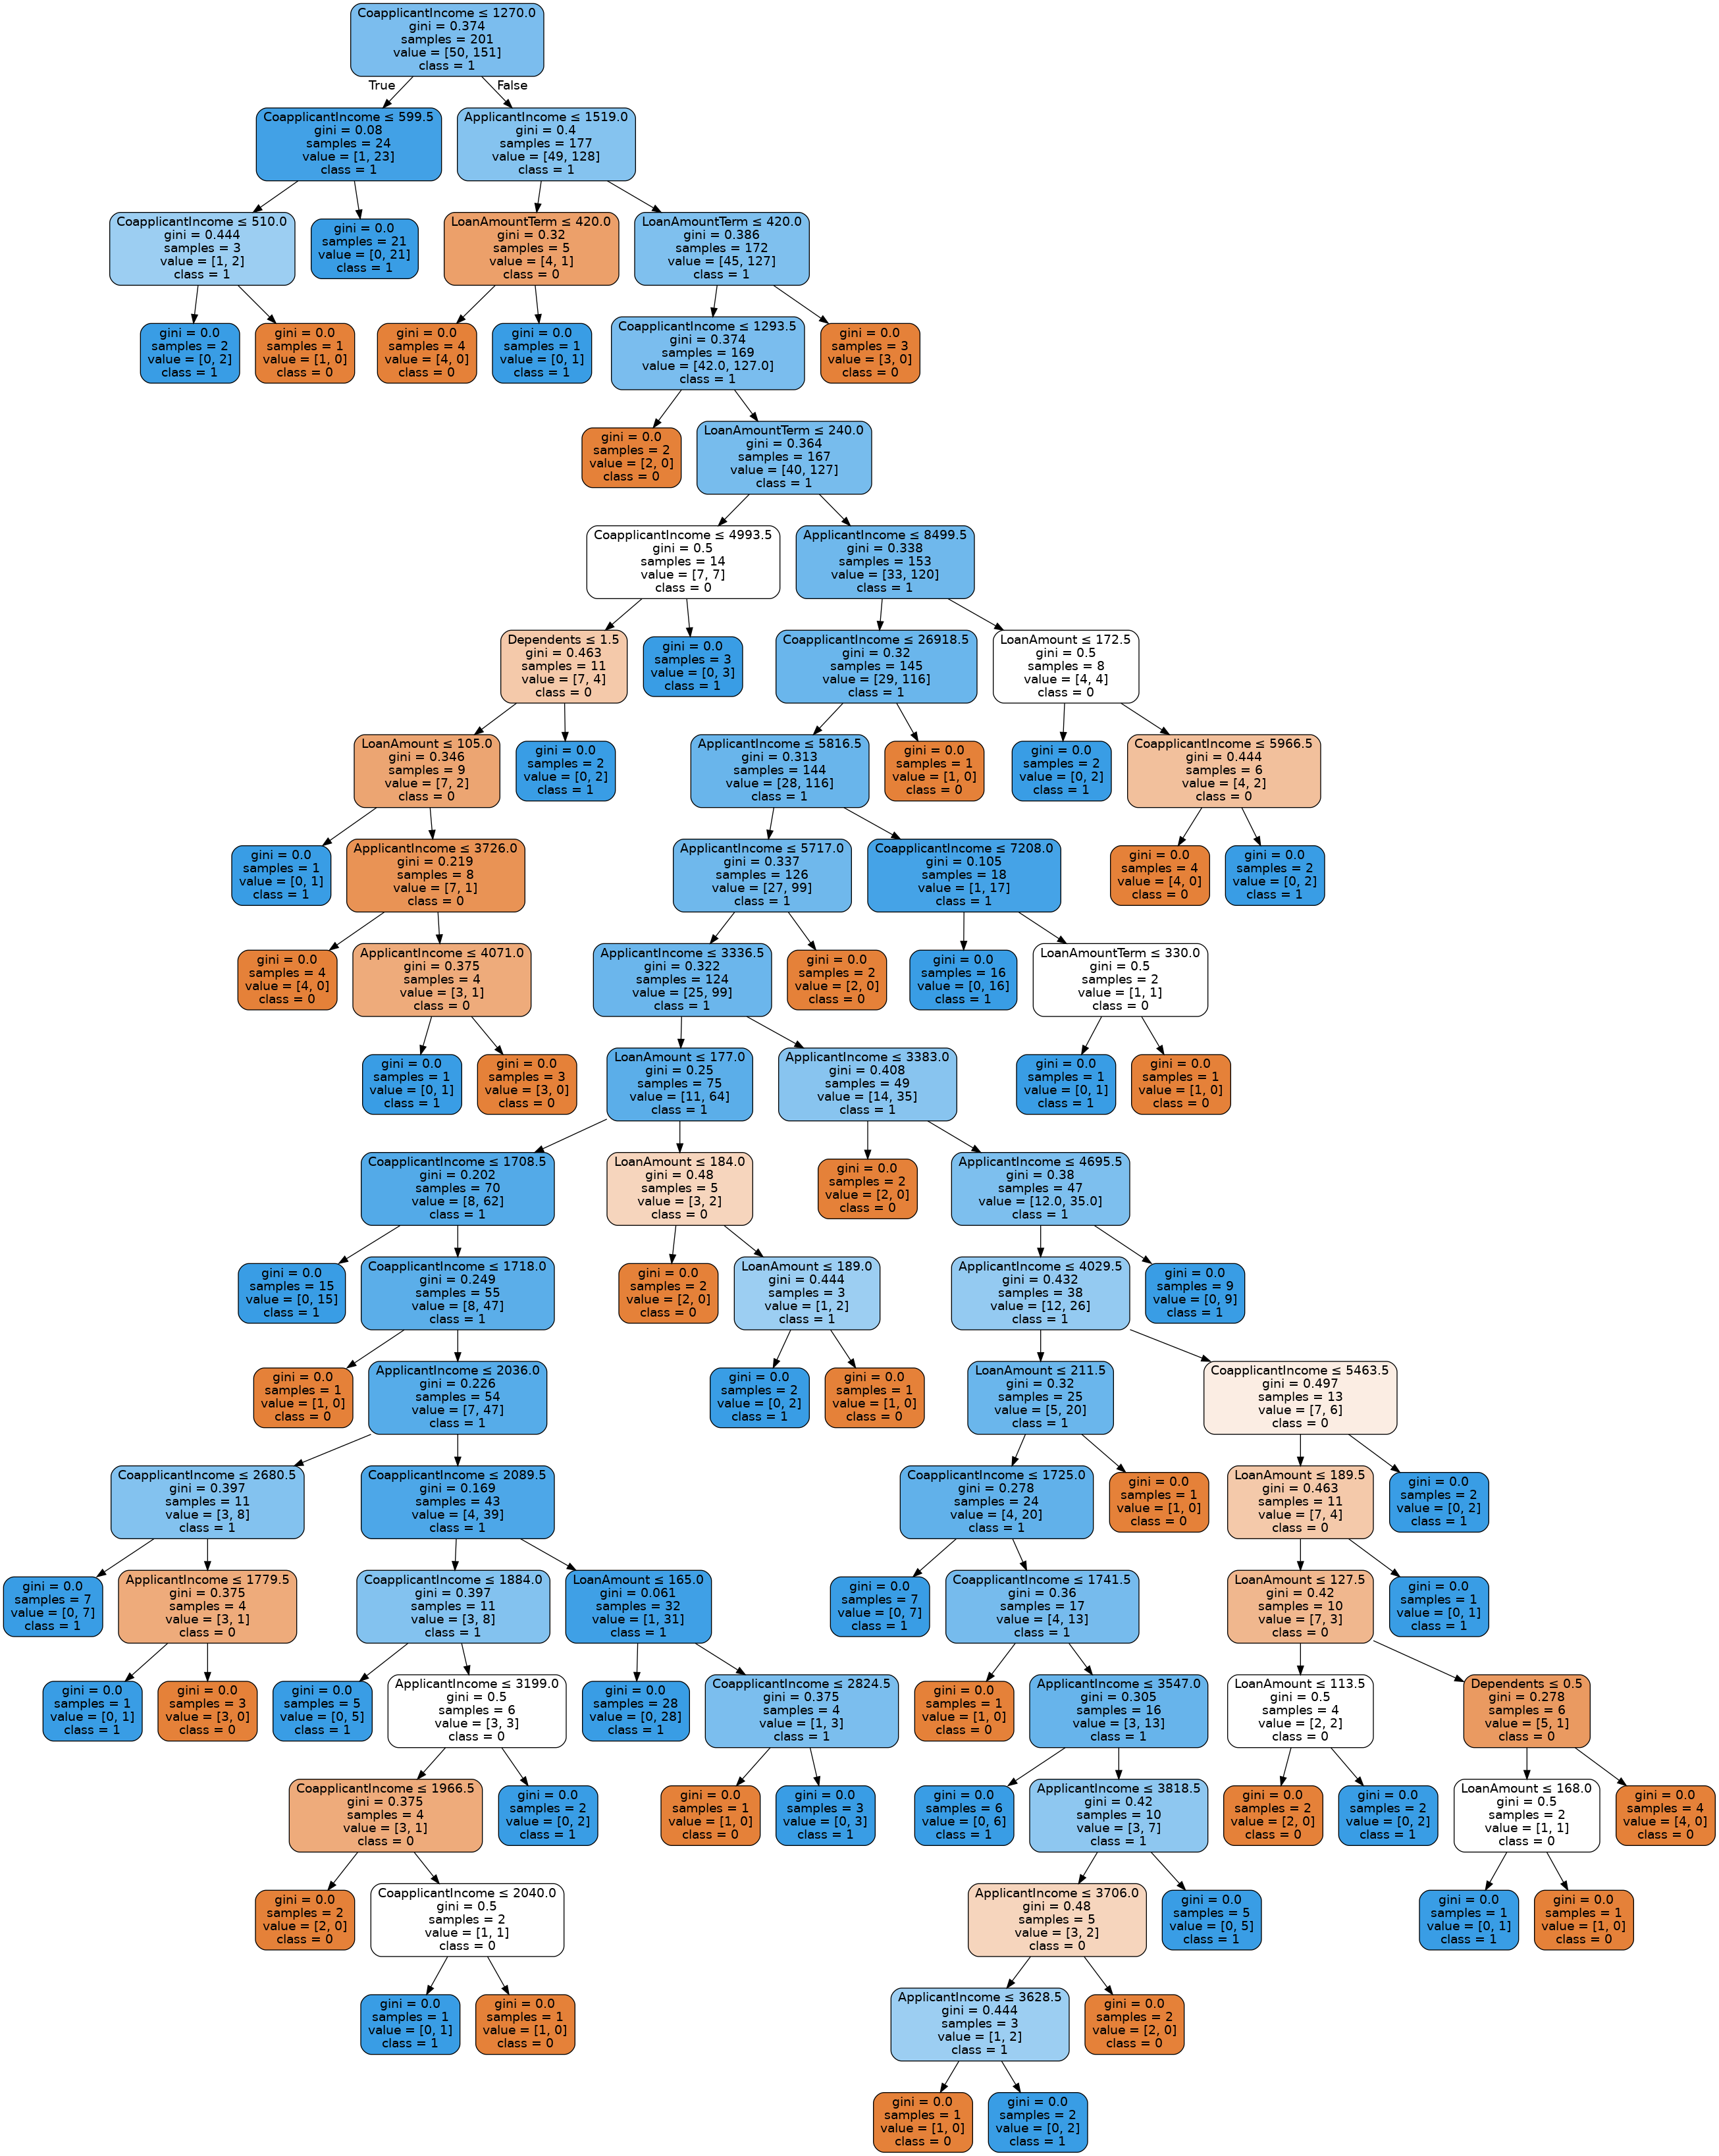

In [137]:
feature_cols = ['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount','LoanAmountTerm']

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, 
                rounded=True,
                special_characters=True,
                feature_names = feature_cols,
                class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('arbol-enorme.png')
Image(graph.create_png())

Vemos que el árbol generado es enorme. Intentemos **podarlo** para conseguir la misma predicción pero con menos nodos.

In [138]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

clf = clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)

print('Accuracy of CT classifier on training set: {:.2f}'.format(clf.score(x_train, y_train)))
print('Accuracy of CT classifier on test set: {:.2f}'.format(clf.score(x_test, y_test)))

Accuracy of CT classifier on training set: 0.79
Accuracy of CT classifier on test set: 0.67


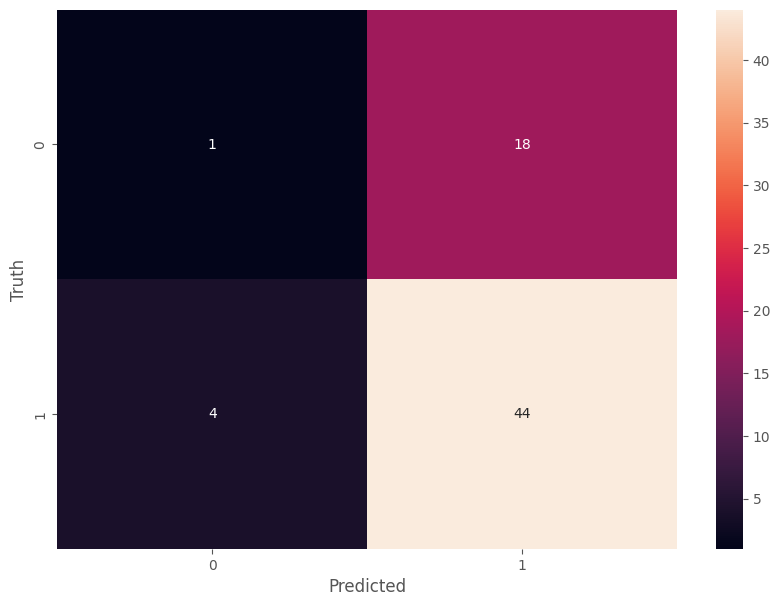

In [139]:
pred = clf.predict(x_test)
cm = confusion_matrix(y_test, pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

plt.show()

Podemos ver que el *cambio no es muy sustancial*. Dibujemos ahora el árbol de decisión.

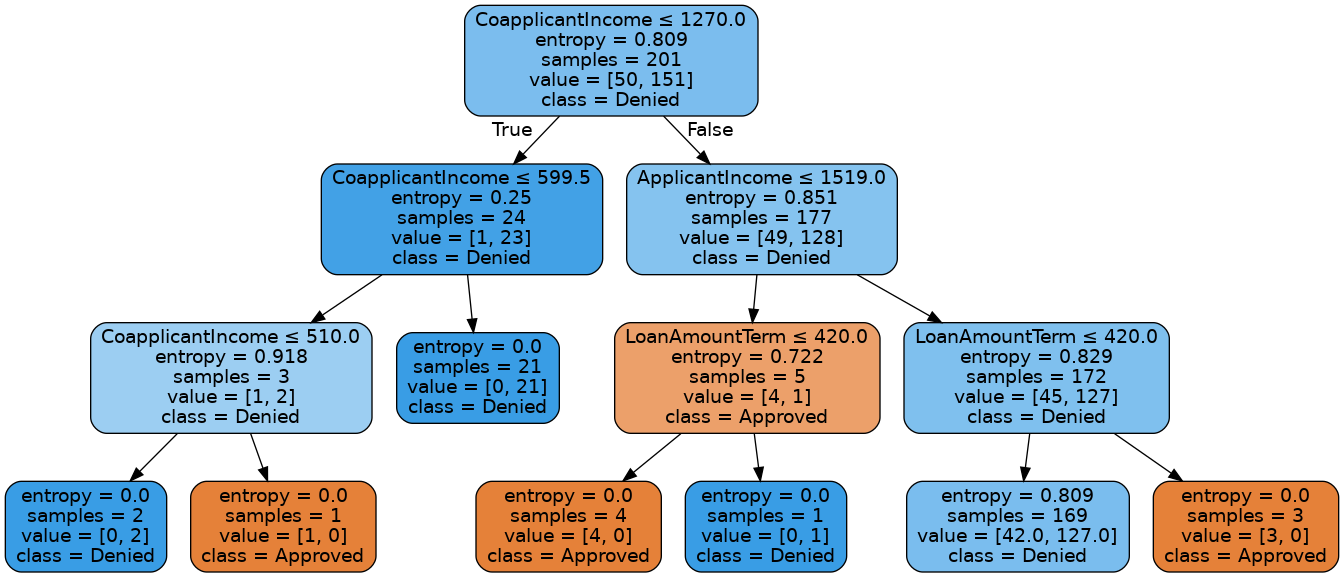

In [140]:
feature_cols = ['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount','LoanAmountTerm']

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                class_names=['Approved', 'Denied'], # Ajusta los nombres de las clases según tus datos
                filled=True, 
                rounded=True,
                special_characters=True,
                feature_names = feature_cols)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('arbol-sin-podar.png')
Image(graph.create_png())

Este árbol se **entiende** mucho **mejor** que el anterior.

## Naive Bayes

Hagamos ahora el clasificador **naive Bayes**. De nuevo, comenzamos preparando nuestros conjuntos para la validación cruzada.

In [141]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

In [142]:
# Llamamos a la función de la librería
nv = GaussianNB()
nv = nv.fit(x_train, y_train)
y_pred = nv.predict(x_test)

In [143]:
# Mostramos los resultados
print('Accuracy of classifier on training set: {:.2f}'.format(nv.score(x_train, y_train)))
print('Accuracy of classifier on test set: {:.2f}'.format(nv.score(x_test, y_test)))

Accuracy of classifier on training set: 0.71
Accuracy of classifier on test set: 0.70


Veamos su **matriz de confusión**.

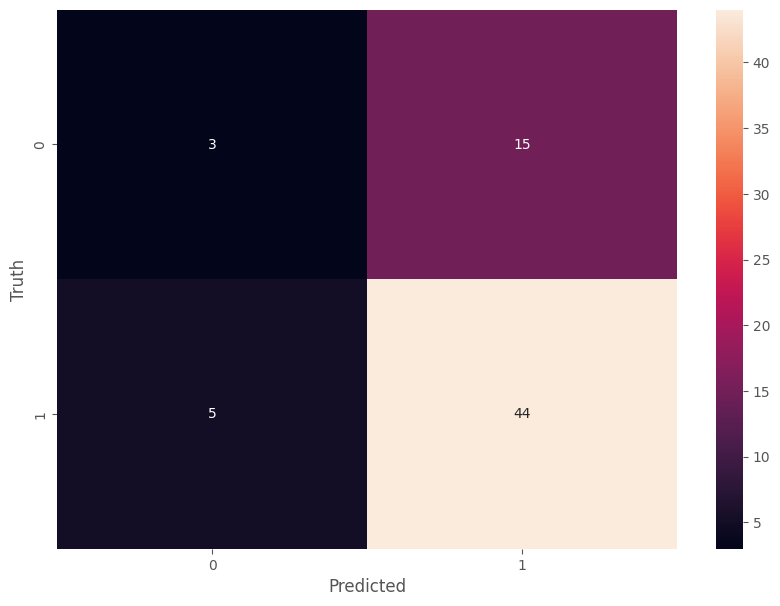

In [144]:
pred = nv.predict(x_test)
cm = confusion_matrix(y_test, pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

plt.show()

Volvemos a tener el **primer problema** de antes, nuestro clasificador etiqueta todo como "sí" y así tiene un gran número de aciertos.

# Tratando los datos

### Datos erróneos

Antes de nada, traeremos la base de datos de nuevo. Los primeros datos que vamos a arreglar son:
- Los datos '3+' de Dependents
- Los datos de Coaplicant que tienen números con '.'
- Tratamiento de datos 'atípicos'
- Los datos vacíos

In [145]:
dataframe = pd.read_csv(r"homeLoanAproval.csv",sep=',')

# Cambiamos los '3+' por '3'
dataframe['Dependents'] = dataframe['Dependents'].replace('3+', 3)
# Lo pasamos a numérico
dataframe['Dependents'] = dataframe['Dependents'].apply(pd.to_numeric)

# Arreglamos los números de Coaplicant
dataframe['CoapplicantIncome'] = dataframe['CoapplicantIncome'].replace('\.', '', regex=True)
dataframe['CoapplicantIncome'] = dataframe['CoapplicantIncome'].apply(pd.to_numeric)

dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    float64
 4   Education          614 non-null    object 
 5   SelfEmployed       582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    int64  
 8   LoanAmount         592 non-null    float64
 9   LoanAmountTerm     600 non-null    float64
 10  PropertyArea       614 non-null    object 
 11  LoanStatus         614 non-null    object 
dtypes: float64(3), int64(2), object(7)
memory usage: 57.7+ KB


In [146]:
# Quitamos la columna del ID, pues no la usaremos
dataframe = dataframe.drop('Loan_ID', axis=1)

# También quitaremos la columna del género, pues no buscamos clasificar en base a él
dataframe = dataframe.drop('Gender', axis=1)

In [147]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Married            611 non-null    object 
 1   Dependents         599 non-null    float64
 2   Education          614 non-null    object 
 3   SelfEmployed       582 non-null    object 
 4   ApplicantIncome    614 non-null    int64  
 5   CoapplicantIncome  614 non-null    int64  
 6   LoanAmount         592 non-null    float64
 7   LoanAmountTerm     600 non-null    float64
 8   PropertyArea       614 non-null    object 
 9   LoanStatus         614 non-null    object 
dtypes: float64(3), int64(2), object(5)
memory usage: 48.1+ KB


In [148]:
# Eliminamos los outliers
dataframe = dataframe[dataframe['ApplicantIncome'] < 20000]
dataframe = dataframe[dataframe['CoapplicantIncome'] < 10000]
dataframe = dataframe[dataframe['LoanAmount'] < 400]
dataframe = dataframe[dataframe['LoanAmountTerm'] < 500]

In [149]:
# En los datos vacíos o nan, pondremos la media en los datos numéricos y la moda en los categóricos
dataframe['Married'] = dataframe['Married'].fillna(dataframe['Married'].mode()[0])
dataframe['Dependents'] = dataframe['Dependents'].fillna(dataframe['Dependents'].mean())
dataframe['Education'] = dataframe['Education'].fillna(dataframe['Education'].mode()[0])
dataframe['SelfEmployed'] = dataframe['SelfEmployed'].fillna(dataframe['SelfEmployed'].mode()[0])
dataframe['ApplicantIncome'] = dataframe['ApplicantIncome'].fillna(dataframe['ApplicantIncome'].mean())
dataframe['CoapplicantIncome'] = dataframe['CoapplicantIncome'].fillna(dataframe['CoapplicantIncome'].mean())
dataframe['LoanAmount'] = dataframe['LoanAmount'].fillna(dataframe['LoanAmount'].mean())
dataframe['LoanAmountTerm'] = dataframe['LoanAmountTerm'].fillna(dataframe['LoanAmountTerm'].mean())
dataframe['PropertyArea'] = dataframe['PropertyArea'].fillna(dataframe['PropertyArea'].mode()[0])


In [150]:
# Comprobamos que no queda ningún dato vacío
dataframe.isnull().sum()

Married              0
Dependents           0
Education            0
SelfEmployed         0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
LoanAmountTerm       0
PropertyArea         0
LoanStatus           0
dtype: int64

In [151]:
dataframe.head()

Married  Dependents     Education SelfEmployed  ApplicantIncome  \
1     Yes         1.0      Graduate           No             4583   
2     Yes         0.0      Graduate          Yes             3000   
3     Yes         0.0  Not Graduate           No             2583   
4      No         0.0      Graduate           No             6000   
5     Yes         2.0      Graduate          Yes             5417   

   CoapplicantIncome  LoanAmount  LoanAmountTerm PropertyArea LoanStatus  
1               1508       128.0           360.0        Rural          N  
2                  0        66.0           360.0        Urban          Y  
3               2358       120.0           360.0        Urban          Y  
4                  0       141.0           360.0        Urban          Y  
5               4196       267.0           360.0        Urban          Y

Ahora, comprobemos si estamos ante un caso de **clases desbalanceadas**.

In [152]:
# Comprobamos el desbalanceo
dataframe['LoanStatus'].value_counts()

LoanStatus
Y    386
N    165
Name: count, dtype: int64

Efectivamente lo estamos, pues tenemos muchos más valores de "Sí" que de "No". Balancearemos las clases haciendo **oversampling**.

In [153]:
# Balanceamos con oversampling
from sklearn.utils import resample

# Separamos por clases
denied = dataframe[dataframe['LoanStatus'] == 'N']
approved = dataframe[dataframe['LoanStatus'] == 'Y']

# Hacemos oversampling de la clase minoritaria
denied_upsampled = resample(denied,
                          replace=True, # sample with replacement
                          n_samples=len(approved), # match number in majority class
                          random_state=27) # reproducible results

# Combinamos las clases
upsampled = pd.concat([approved, denied_upsampled])

# Comprobamos que estén balanceadas
upsampled['LoanStatus'].value_counts()

LoanStatus
Y    386
N    386
Name: count, dtype: int64

In [154]:
# Los clasificadores que estamos usando no aceptan valores categóricos, hay que pasarlos a numéricos
le = LabelEncoder()
for col in upsampled.columns:
    if upsampled[col].dtype == 'object':
        upsampled[col] = le.fit_transform(upsampled[col])

## k-Vecinos

Repitamos el mismo proceso de antes pero con nuestro dataframe mejorado

In [155]:
upsampled.head()

Married  Dependents  Education  SelfEmployed  ApplicantIncome  \
2        1         0.0          0             1             3000   
3        1         0.0          1             0             2583   
4        0         0.0          0             0             6000   
5        1         2.0          0             1             5417   
6        1         0.0          1             0             2333   

   CoapplicantIncome  LoanAmount  LoanAmountTerm  PropertyArea  LoanStatus  
2                  0        66.0           360.0             2           1  
3               2358       120.0           360.0             2           1  
4                  0       141.0           360.0             2           1  
5               4196       267.0           360.0             2           1  
6               1516        95.0           360.0             2           1

<Axes: >

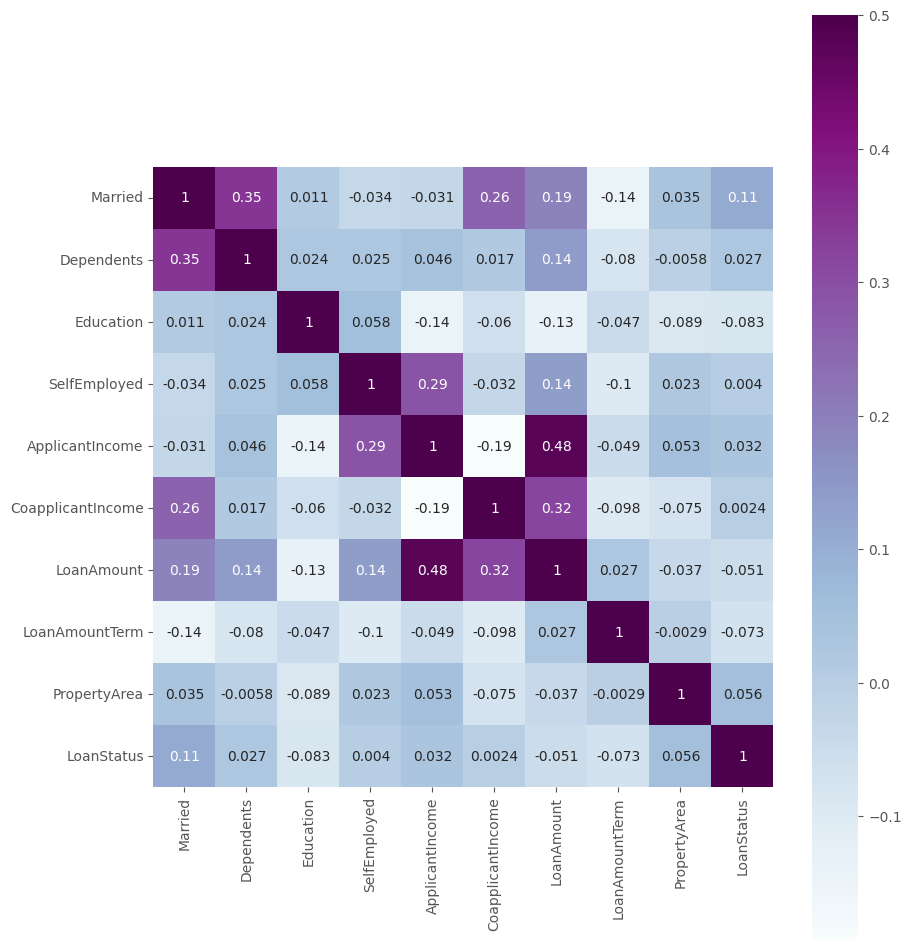

In [156]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf = upsampled.select_dtypes(include=numerics)

# Veamos la correlación entre los datos
matrix = newdf.corr()
f, ax = plt.subplots(figsize=(10, 12))
sns.heatmap(matrix, vmax=.5, square=True, cmap="BuPu",annot=True)

In [157]:
# Quitamos las variables que hacen ruido
upsampled = upsampled.drop('Education', axis=1)
upsampled = upsampled.drop('Dependents', axis=1)
upsampled = upsampled.drop('SelfEmployed', axis=1)
upsampled = upsampled.drop('CoapplicantIncome', axis=1)

In [158]:
# Para el k vecinos, como usa distancias, usaremos solo las numéricas
k_upsampled_fixed = upsampled
k_upsampled_fixed.drop('Married', axis=1)
k_upsampled_fixed.drop('PropertyArea', axis=1)

Married  ApplicantIncome  LoanAmount  LoanAmountTerm  LoanStatus
2          1             3000        66.0           360.0           1
3          1             2583       120.0           360.0           1
4          0             6000       141.0           360.0           1
5          1             5417       267.0           360.0           1
6          1             2333        95.0           360.0           1
..       ...              ...         ...             ...         ...
412        1             6096       218.0           360.0           0
65         1             5726       258.0           360.0           0
148        0            10000       225.0           360.0           0
541        0             2138        99.0           360.0           0
195        1             3125       170.0           360.0           0

[772 rows x 5 columns]

In [159]:
k_upsampled_fixed.head()

Married  ApplicantIncome  LoanAmount  LoanAmountTerm  PropertyArea  \
2        1             3000        66.0           360.0             2   
3        1             2583       120.0           360.0             2   
4        0             6000       141.0           360.0             2   
5        1             5417       267.0           360.0             2   
6        1             2333        95.0           360.0             2   

   LoanStatus  
2           1  
3           1  
4           1  
5           1  
6           1

In [160]:
x = k_upsampled_fixed.drop('LoanStatus', axis=1)
y = k_upsampled_fixed['LoanStatus'].values

In [161]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

In [162]:
n_neighbors = 7

knn = KNeighborsClassifier(n_neighbors)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [163]:
print('Accuracy of classifier on training set: {:.2f}'.format(knn.score(x_train, y_train)))
print('Accuracy of classifier on test set: {:.2f}'.format(knn.score(x_test, y_test)))

Accuracy of classifier on training set: 0.72
Accuracy of classifier on test set: 0.66


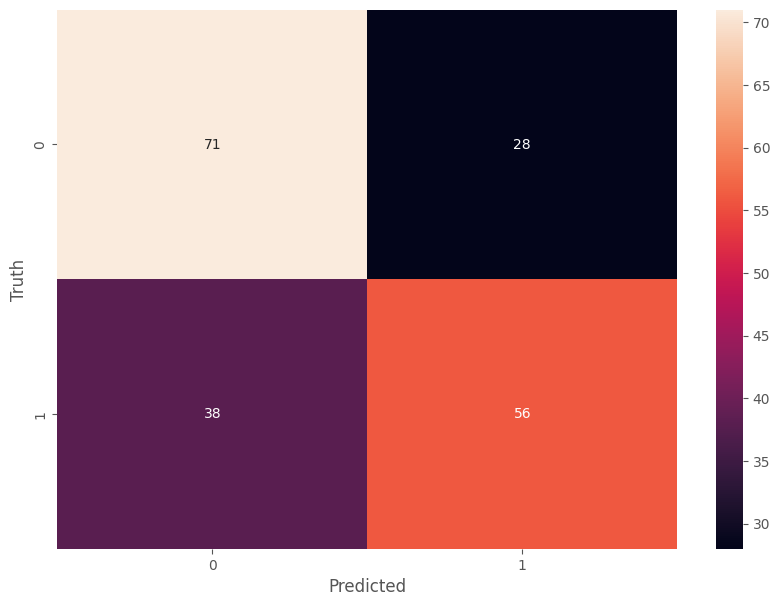

In [164]:
pred = knn.predict(x_test)
cm = confusion_matrix(y_test, pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

plt.show()

Podemos ver que nuestro clasificador **ya no clasifica todo en "sí"** como antes, ahora razona un poco.

## Árbol de clasificación

Ya quitamos las variables que hacían ruido en el apartado anterior.

In [165]:
upsampled.head()

Married  ApplicantIncome  LoanAmount  LoanAmountTerm  PropertyArea  \
2        1             3000        66.0           360.0             2   
3        1             2583       120.0           360.0             2   
4        0             6000       141.0           360.0             2   
5        1             5417       267.0           360.0             2   
6        1             2333        95.0           360.0             2   

   LoanStatus  
2           1  
3           1  
4           1  
5           1  
6           1

In [166]:
x = upsampled.drop('LoanStatus', axis=1)
y = upsampled['LoanStatus'].values

In [167]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

In [168]:
clf = DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

In [169]:
print('Accuracy of classifier on training set: {:.2f}'.format(clf.score(x_train, y_train)))
print('Accuracy of classifier on test set: {:.2f}'.format(clf.score(x_test, y_test)))

Accuracy of classifier on training set: 1.00
Accuracy of classifier on test set: 0.78


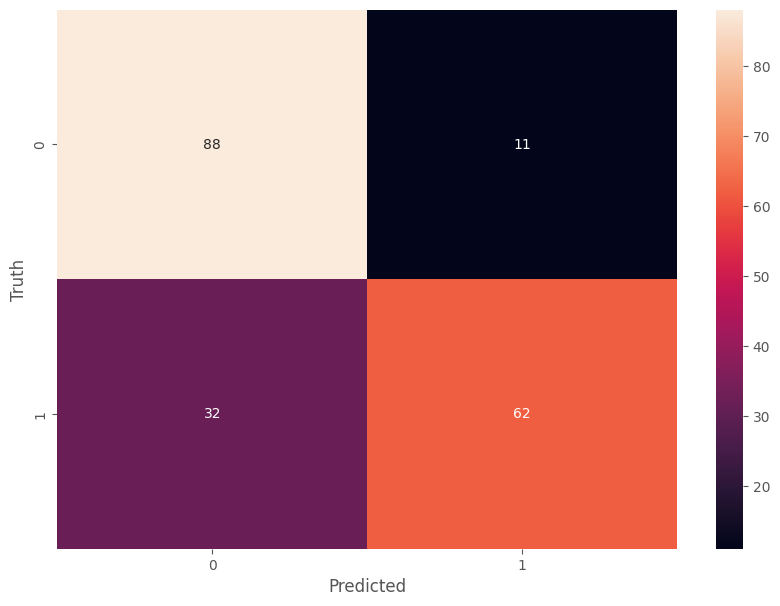

In [170]:
pred = clf.predict(x_test)
cm = confusion_matrix(y_test, pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

plt.show()

Veamos el árbol generado.

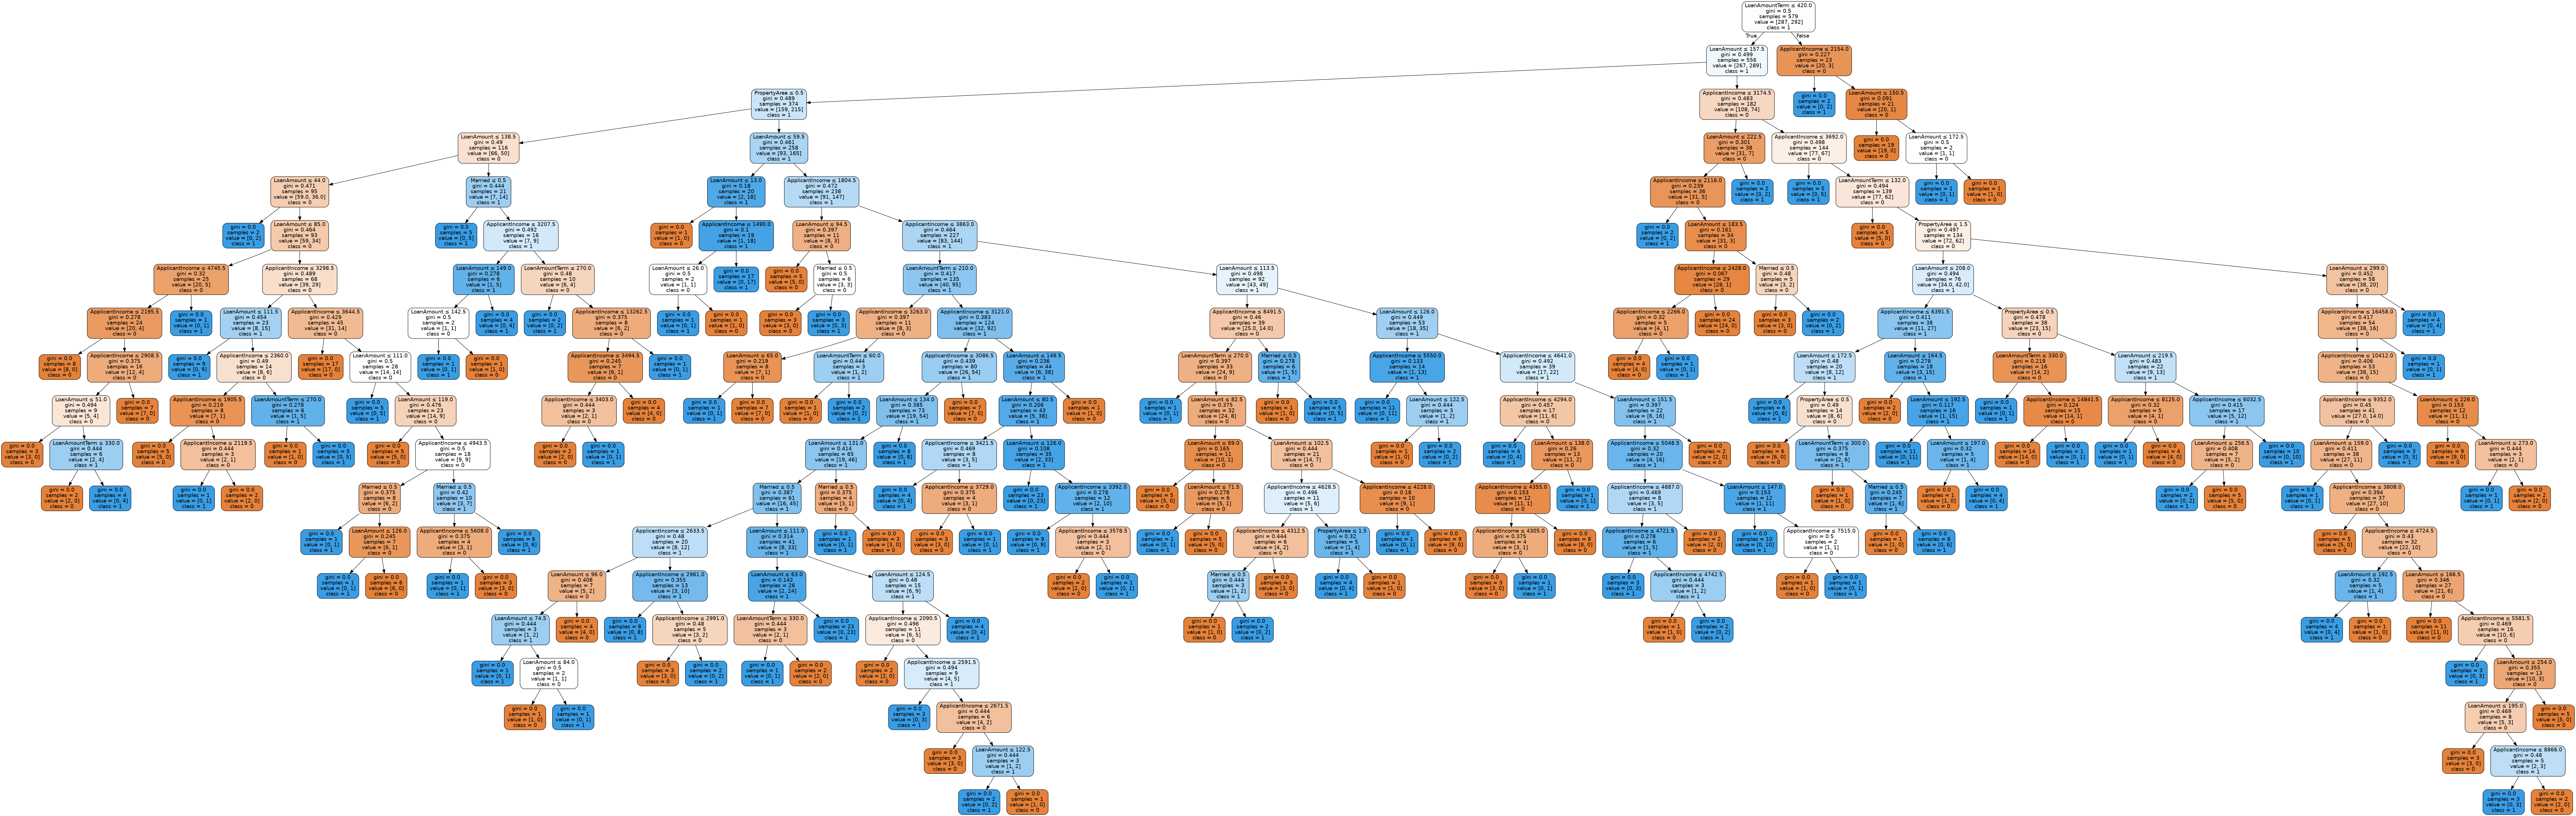

In [171]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, 
                rounded=True,
                special_characters=True,
                feature_names = upsampled.columns.drop('LoanStatus'),
                class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('arbol-sin-poda.png')
Image(graph.create_png())

Podemos para que se vea mejor (perdemos calidad del clasificador).

In [172]:
clf = DecisionTreeClassifier(criterion="gini", max_depth=6)  # Ajusta el ccp_alpha según sea necesario

clf = clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)

print('Accuracy of classifier on training set: {:.2f}'.format(clf.score(x_train, y_train)))
print('Accuracy of classifier on test set: {:.2f}'.format(clf.score(x_test, y_test)))

Accuracy of classifier on training set: 0.68
Accuracy of classifier on test set: 0.60


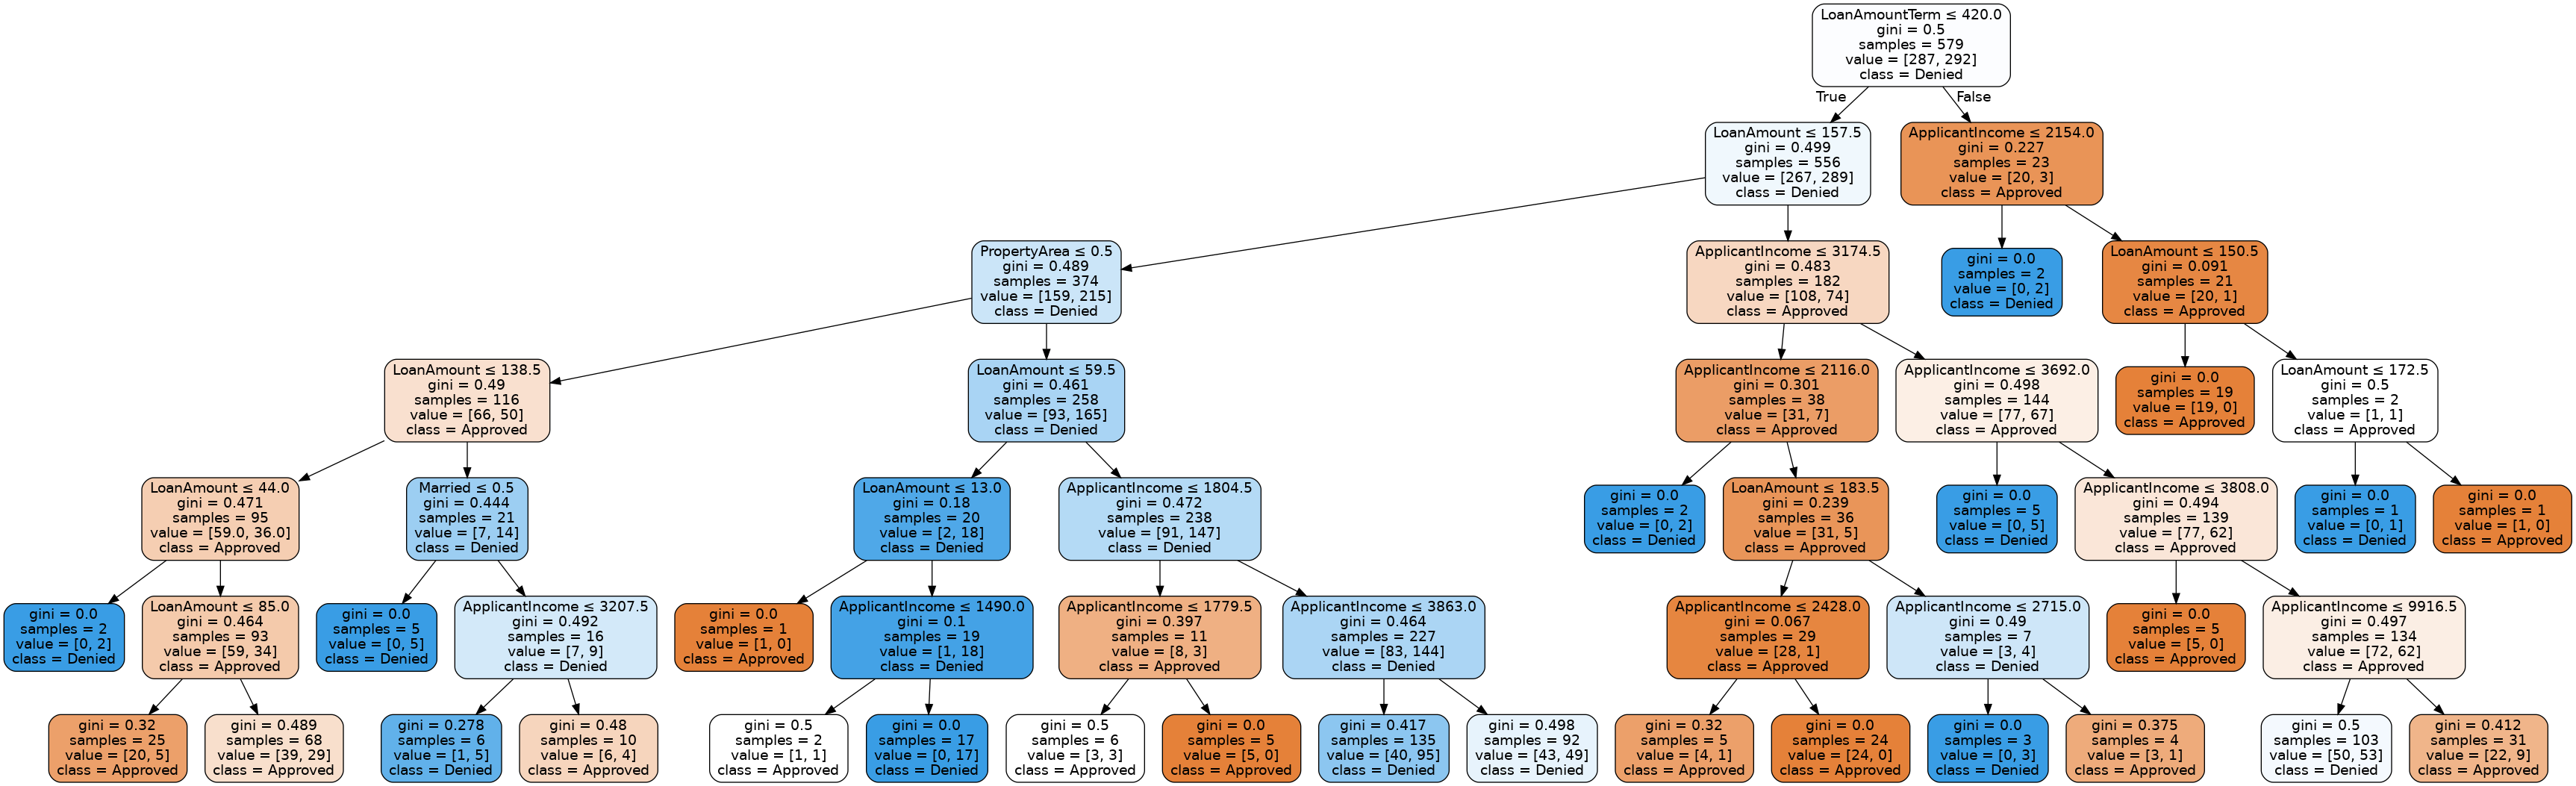

In [173]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                class_names=['Approved', 'Denied'], # Ajusta los nombres de las clases según tus datos
                filled=True, 
                rounded=True,
                special_characters=True,
                feature_names = upsampled.columns.drop('LoanStatus'))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('arbol-podado.png')
Image(graph.create_png())

## Naive-Bayes

In [174]:
upsampled.head()

Married  ApplicantIncome  LoanAmount  LoanAmountTerm  PropertyArea  \
2        1             3000        66.0           360.0             2   
3        1             2583       120.0           360.0             2   
4        0             6000       141.0           360.0             2   
5        1             5417       267.0           360.0             2   
6        1             2333        95.0           360.0             2   

   LoanStatus  
2           1  
3           1  
4           1  
5           1  
6           1

In [175]:
# Reestablecemos las variables
x = upsampled.drop('LoanStatus', axis=1)
y = upsampled['LoanStatus'].values

In [176]:
# Separamos los datos
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

In [177]:
nv = GaussianNB()
nv = nv.fit(x_train, y_train)
y_pred = nv.predict(x_test)
y_pred

array([0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0])

In [178]:
print('Accuracy of classifier on training set: {:.2f}'.format(nv.score(x_train, y_train)))
print('Accuracy of classifier on test set: {:.2f}'.format(nv.score(x_test, y_test)))

Accuracy of classifier on training set: 0.57
Accuracy of classifier on test set: 0.54


No vemos una mejoría notable en los porcentajes de acierto, veamos mejor la matriz.

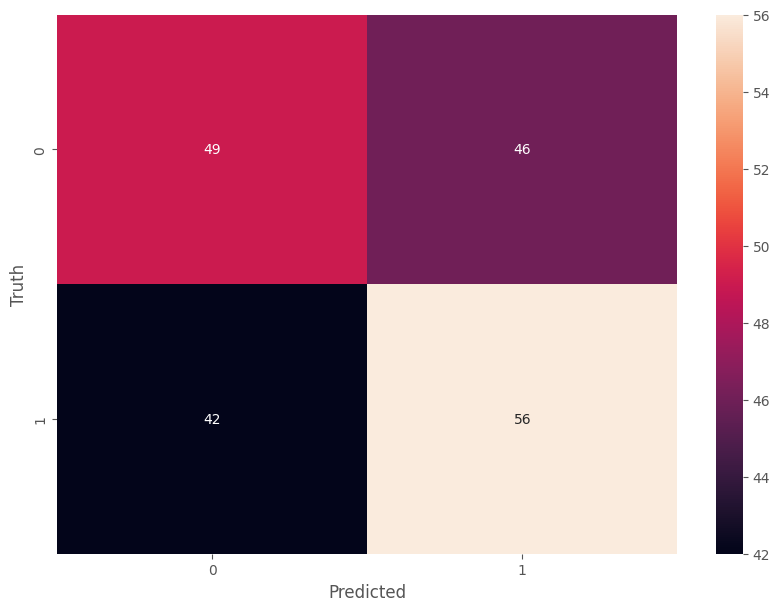

In [179]:
pred = nv.predict(x_test)
cm = confusion_matrix(y_test, pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

plt.show()

En este caso nuestro clasificador ha empeorado. No solo **no se decanta por ninguna opción**, más bien parece colocar la mitad en cada uno. Probablemente Naive Bayes es capaz de detectar que, en nuestros datos, hay un 50% de sies y un 50% de noes. Probablemente a este algoritmo le venga mejor no balancear las clases.